In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from scipy.stats import zscore
import os
import sys
import logging
import datetime

loggers = {}

In [2]:
def setup_custom_logger(name, _id=''):
    global loggers

    if loggers.get(name):
        return loggers.get(name)
    
    formatter = logging.Formatter(fmt='%(asctime)s %(levelname)-2s [%(name)s] %(message)s',
                                  datefmt='%Y-%m-%d %H:%M:%S')
    handler = logging.FileHandler('log.txt', mode='a')
    handler.setFormatter(formatter)
    screen_handler = logging.StreamHandler(stream=sys.stdout)
    screen_handler.setFormatter(formatter)
    logger = logging.getLogger(name)
    logger.setLevel(logging.INFO)
    logger.addHandler(handler)
    logger.addHandler(screen_handler)
    loggers[name] = logger
    return logger

# Data Processing

In [3]:
class DataProcessor:
    def __init__(self, prepare_data=True):
        """Class to create, store, and fetch data
        """
        self.lg = setup_custom_logger('DataProcessor: ' + str(int(datetime.datetime.now().timestamp())))
        self.lg.info('DataProcessor Initializing...')
        
        if prepare_data:
            if os.path.isfile('data/master.pickle'):
                self.lg.info('Loading Master Data')
                self.clean_df = self.load_data('data/master.pickle')
            else:
                self.lg.error('data/master.pickle is required')
                raise FileNotFoundError('data/master.pickle is required')
                
            if os.path.isfile('data/state_space.pickle'):
                self.lg.info('Loading State Data')
                self.state = self.load_data('data/state_space.pickle')
            else:
                self.lg.info('Generated State Data')
                self.state = self.prepare_state_space()
                
        self.lg.info("DataProcessing Initialized!")
        
    def load_data(self, file):
        return pd.read_pickle(file)
        
    def get_unique_pairs(self):
        self.pairs = self.clean_df.pair.unique()
        return self.pairs
    
    def slice_data_by_pair(self, pair):
        return self.clean_df[self.clean_df.pair == pair]
    
    def gen_next_open(self, d):
        d['next_open'] = d.open.shift(-1)
        return d
    
    def sin_encode(self, t, T):
        return np.sin(2 * np.pi * (t / T))

    def encode_temporal(self, index, name):
        _index = index
        if name == "day_of_week":
            index = index.dayofweek
        if name == "hour":
            index = index.hour
        if name == "minute":
            index = index.minute

        T = len(index.unique())
        return pd.Series(self.sin_encode(index, T), index=_index, name=name)
    
    def log_return(self, series):
        return np.log(series) - np.log(series.shift(1))
    
    def rolling_zscore(self, arr):
        return zscore(arr)[-1]
    
    def gen_pos_encoding(self, dff):
        return pd.DataFrame(np.zeros(shape=(dff.index.size, 3)),
                      columns=['pos_short', 'pos_neutral', 'pos_long'],
                      index=dff.index)
    
    def gen_log_return(self, series, zscore_roll=96, lookback=8, clip=(-10,10)):
        log_ret = self.log_return(series)
        norms = log_ret.rolling(zscore_roll).apply(self.rolling_zscore, raw=False)
        norms = norms.clip(*clip)

        log_returns = {}
        for s in range(lookback):
            log_returns['{}_log_returns_{}'.format(series.name, s)] = norms.shift(s)

        return pd.DataFrame(log_returns)
    
    def calculate_meta_variables(self, dff):
        # Time Encoding
        dff = dff.join(self.encode_temporal(dff.index, name='day_of_week'))
        dff = dff.join(self.encode_temporal(dff.index, name='hour'))
        dff = dff.join(self.encode_temporal(dff.index, name='minute'))

        return dff


    def calculate_market_variables(self, dff, label=''):
        # Market Feature
        _df = self.gen_log_return(dff.next_open)
        _df = _df.join(self.gen_log_return(dff.volume))
        _df.columns = [str(col) + '_' + label for col in _df.columns]
        
        return _df
    
    def prepare_state_space(self):
        self.state = None
        
        self.dfps = {} # DataFrame Dictionary per Pair
        pairs = self.get_unique_pairs()
        
        for pair in pairs:
            self.lg.info('Preparing Data for {}'.format(pair))
            _df = self.slice_data_by_pair(pair).copy()
            _df = self.gen_next_open(_df)
            _df = self.calculate_market_variables(_df, pair.replace('/', '_'))
            self.dfps[pair] = _df
            if type(self.state) == type(None):
                self.state = _df
            else:
                self.state = self.state.join(_df)
            
        # Position Encoding
        self.state = self.calculate_meta_variables(self.state)
        self.state = self.state.join(self.gen_pos_encoding(self.state))
        return self.state
    
    def combine_state_spaces(self):
        ds = DataProcessor(False)
        df = None
        for key in ds.dfps:
            if type(df) == type(None):
                df = self.dfps[key]
            else:
                df = df.join(self.dfps[key])

        df = self.calculate_meta_variables(df)
        df = self.join(ds.gen_pos_encoding(df))
        return df
        #df.to_pickle('data/state_space.pickle')

In [4]:
dp = DataProcessor()

2018-07-31 21:09:58 INFO [DataProcessor: 1533085798] DataProcessor Initializing...
2018-07-31 21:09:58 INFO [DataProcessor: 1533085798] Loading Master Data
2018-07-31 21:09:58 INFO [DataProcessor: 1533085798] Loading State Data
2018-07-31 21:09:58 INFO [DataProcessor: 1533085798] DataProcessing Initialized!


# Data Managing

In [5]:
class DataManager:
    def __init__(self, dp):
        """Class to manage preprocessed data
        """
        
        self.lg = setup_custom_logger('DataManager: ' + str(int(datetime.datetime.now().timestamp())))
        self.lg.info('DataManager Initializing...')
        
        self.dp = dp
        self.data = dp.clean_df
        self.state = dp.state
        self.pairs = self.data.pair.unique()
        self.training_columns = self.get_training_columns()
        
        self.lg.info('DataManager Initialized!')
        
    def get_pairs(self):
        return self.pairs
    
    def get_training_columns(self):
        self.training_columns = self.state.columns
        return self.training_columns
    
    def get_slice_from_pair(self, pair):
        return self.dp.gen_next_open(self.data[self.data.pair == pair])

In [6]:
dm = DataManager(dp)

2018-07-31 21:09:58 INFO [DataManager: 1533085798] DataManager Initializing...
2018-07-31 21:09:58 INFO [DataManager: 1533085798] DataManager Initialized!


In [7]:
dm.get_slice_from_pair('EUR/USD')

/home/nathan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,pair,open,close,high,low,volume,next_open
datetime,,,,,,,
2012-01-02 00:00:00,EUR/USD,1.294840,1.294550,1.294840,1.294450,119,1.294570
2012-01-02 00:15:00,EUR/USD,1.294570,1.294720,1.294740,1.294130,110,1.294705
2012-01-02 00:30:00,EUR/USD,1.294705,1.294830,1.294950,1.294705,37,1.294835
2012-01-02 00:45:00,EUR/USD,1.294835,1.294370,1.294970,1.294370,337,1.294500
2012-01-02 01:00:00,EUR/USD,1.294500,1.294315,1.294770,1.294285,267,1.294310
2012-01-02 01:15:00,EUR/USD,1.294310,1.294270,1.294615,1.294190,209,1.294305
2012-01-02 01:30:00,EUR/USD,1.294305,1.294420,1.294525,1.294305,223,1.294420
2012-01-02 01:45:00,EUR/USD,1.294420,1.293975,1.294435,1.293865,210,1.294005
2012-01-02 02:00:00,EUR/USD,1.294005,1.293675,1.294030,1.293645,175,1.293660


In [8]:
from training import Environment, Agent
%load_ext autoreload
%autoreload 2

/home/nathan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


/home/nathan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/nathan/forex_ml/training.py:43: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=198, units=128)`
  model.add(Dense(output_dim=128, activation='relu', input_dim=self.stateCnt))
/home/nathan/forex_ml/training.py:44: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=128)`
  model.add(Dense(output_dim=128, activation='relu'))
/home/nathan/forex_ml/training.py:45: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="linear", units=3)`
  model.add(Dense(output_dim=self.actionCnt, activation='linear'))
/home/nathan/forex_ml/training.py:5

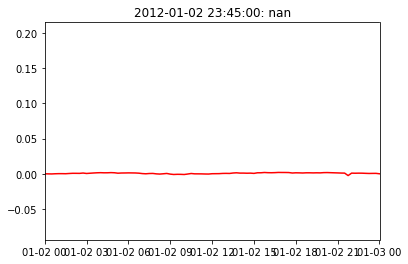

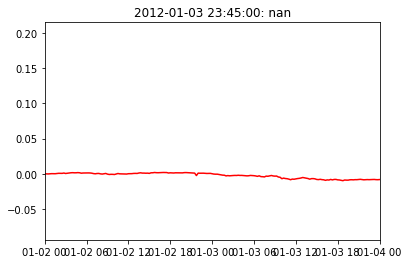

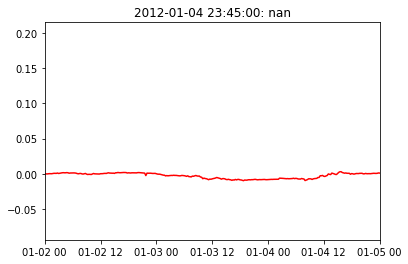

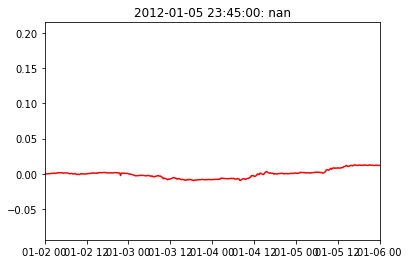

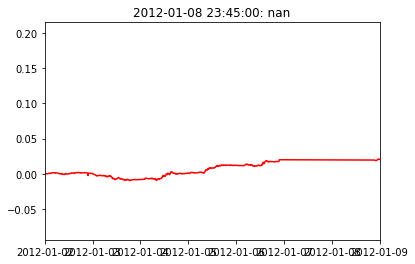

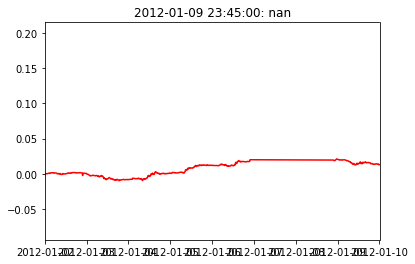

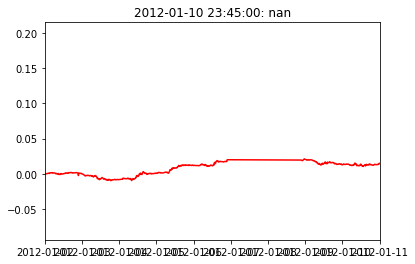

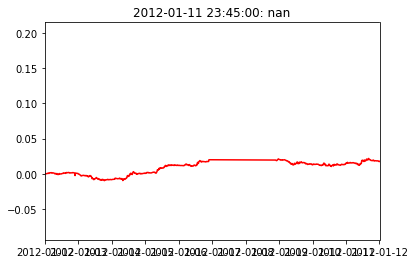

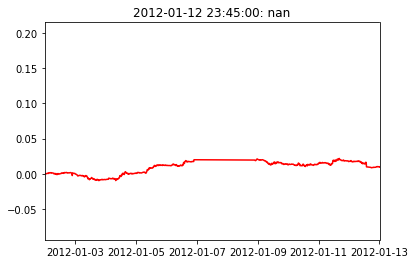

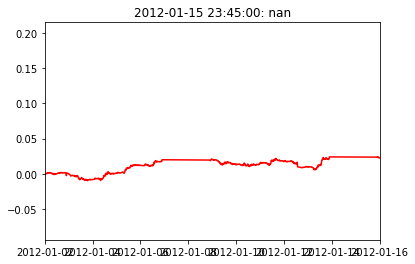

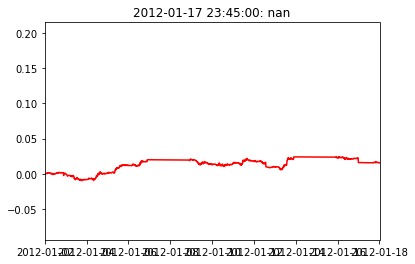

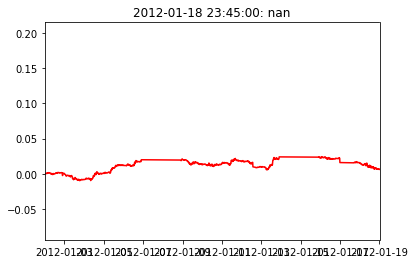

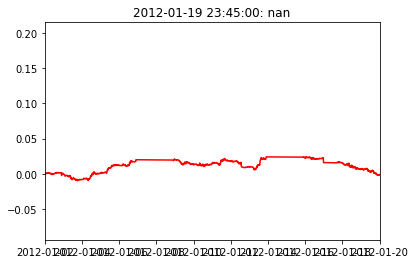

KeyboardInterrupt: 

In [11]:
env = Environment(dm.get_slice_from_pair('EUR/USD'), dp.state)
agent = Agent(dp.state.columns.size, 3)
env.run(agent)
agent.brain.model.save("brain.h5")